In [1]:
!pip install matplotlib
!pip install scipy
#This version is after adding regularizers, for the details of code comment, please check ResNet.ipynb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


import keras
from keras import Model
import keras.layers as layers
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import image_dataset_from_directory, Sequence
from keras.preprocessing.image import ImageDataGenerator

from keras import datasets
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-03-22 09:03:16.804893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 09:03:17.453133: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 09:03:19.686474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-22 09:03:19.686615: W tensorflow/

In [2]:
img_train_path = os.path.join("DATASET","TRAIN")
img_test_path = os.path.join("DATASET","TEST")
img_SET1_path = os.path.join("DATASET","CROSS/SET1")
img_SET2_path = os.path.join("DATASET","CROSS/SET2")
img_SET3_path = os.path.join("DATASET","CROSS/SET3")
img_SET1_SET2_path = os.path.join("DATASET","CROSS/SET1_SET2")
img_SET1_SET3_path = os.path.join("DATASET","CROSS/SET1_SET3")
img_SET2_SET3_path = os.path.join("DATASET","CROSS/SET2_SET3")

data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
BATCH_SIZE = 128

raw_generator = data_gen.flow_from_directory(img_train_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET1_generator = data_gen.flow_from_directory(img_SET1_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET2_generator = data_gen.flow_from_directory(img_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET3_generator = data_gen.flow_from_directory(img_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET1_generator = data_gen.flow_from_directory(img_SET1_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET2_generator = data_gen.flow_from_directory(img_SET1_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET3_generator = data_gen.flow_from_directory(img_SET2_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
test_generator = data_gen.flow_from_directory(img_test_path, target_size=(256,256), batch_size=BATCH_SIZE)

Found 22564 images belonging to 2 classes.
Found 7447 images belonging to 2 classes.
Found 7672 images belonging to 2 classes.
Found 7445 images belonging to 2 classes.
Found 15119 images belonging to 2 classes.
Found 14892 images belonging to 2 classes.
Found 15117 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [3]:
img, _= next(raw_generator)
print(img.shape)

(128, 256, 256, 3)


In [4]:
def rebuild_model():
    global pretrained_model
    global model
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

    model = keras.Sequential()

    model.add(pretrained_model)

    model.add(Flatten())
    #adding regularizers
    model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.2)))
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.2)))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.2)))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=True)
rebuild_model()
pretrained_model.summary()

2023-03-22 09:03:24.458260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 09:03:24.682290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 09:03:24.682536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 09:03:24.687029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 09:03:24.687196: I tensorflow/compiler/xla/stream_executo

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [5]:
# reduce time and overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,801,282
Trainable params: 24,748,162
No

Epoch 1/25


2023-03-22 09:03:42.975012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-22 09:03:55.656739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 09:03:55.838110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
 

2023-03-22 09:03:57.154192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 1024 spatial: 16 16  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 1024 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 09:03:57.168292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 512 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 512 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an i

 51/118 [===========>..................] - ETA: 26s - loss: 94.0904 - accuracy: 0.8747

2023-03-22 09:04:40.131195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 09:04:40.155524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

118/118 [==============================] - 139s 818ms/step - loss: 44.4968 - accuracy: 0.8869 - val_loss: 3.2687 - val_accuracy: 0.4426
Epoch 2/25
118/118 [==============================] - 57s 480ms/step - loss: 0.5399 - accuracy: 0.9131 - val_loss: 1.5083 - val_accuracy: 0.4428
Epoch 3/25
118/118 [==============================] - 56s 475ms/step - loss: 0.2939 - accuracy: 0.9213 - val_loss: 1.2499 - val_accuracy: 0.4430
Epoch 4/25
118/118 [==============================] - 55s 463ms/step - loss: 0.2575 - accuracy: 0.9305 - val_loss: 1.7717 - val_accuracy: 0.4432
Epoch 5/25
118/118 [==============================] - 57s 480ms/step - loss: 0.2445 - accuracy: 0.9352 - val_loss: 1.9311 - val_accuracy: 0.4481
Epoch 6/25
118/118 [==============================] - 55s 461ms/step - loss: 0.2153 - accuracy: 0.9423 - val_loss: 2.3525 - val_accuracy: 0.4484
Epoch 7/25
118/118 [==============================] - 56s 471ms/step - loss: 0.1948 - accuracy: 0.9499 - val_loss: 1.1826 - val_accuracy: 0

2023-03-22 09:18:39.935696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 09:18:40.000110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

20/20 [==============================] - 10s 494ms/step - loss: 0.2603 - accuracy: 0.9184
test loss, test acc: [0.2602516710758209, 0.9184241890907288]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


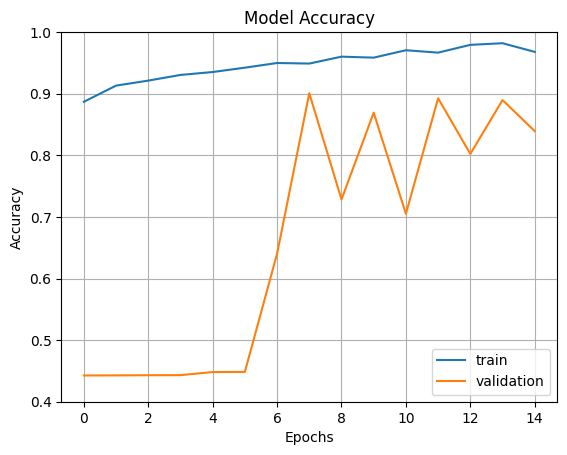

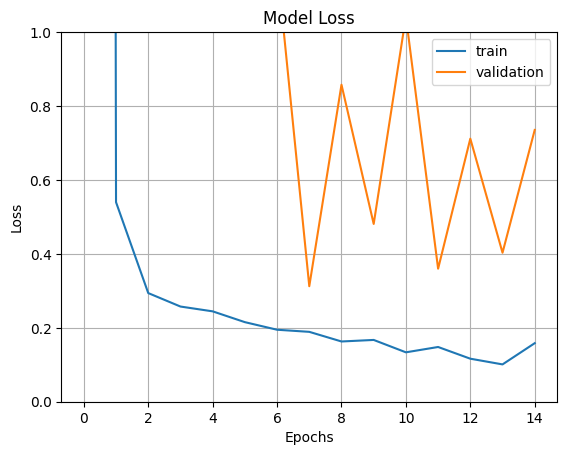

In [6]:
train_generator = CSET1_generator
validation_generator = SET3_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/25
 35/116 [========>.....................] - ETA: 26s - loss: 123.9848 - accuracy: 0.8583

2023-03-22 09:19:23.197294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 09:19:23.263441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

2023-03-22 09:19:23.896193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 128 spatial: 32 32  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 128 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 09:19:24.003305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an ident

116/116 [==============================] - 113s 802ms/step - loss: 44.8977 - accuracy: 0.8893 - val_loss: 2.8736 - val_accuracy: 0.4443
Epoch 2/25
116/116 [==============================] - 52s 446ms/step - loss: 0.5651 - accuracy: 0.9082 - val_loss: 1.7328 - val_accuracy: 0.4431
Epoch 3/25
116/116 [==============================] - 52s 445ms/step - loss: 0.2958 - accuracy: 0.9224 - val_loss: 1.3141 - val_accuracy: 0.4432
Epoch 4/25
116/116 [==============================] - 54s 464ms/step - loss: 0.2588 - accuracy: 0.9288 - val_loss: 1.8661 - val_accuracy: 0.4436
Epoch 5/25
116/116 [==============================] - 54s 463ms/step - loss: 0.2340 - accuracy: 0.9348 - val_loss: 0.9813 - val_accuracy: 0.5801
Epoch 6/25
116/116 [==============================] - 53s 457ms/step - loss: 0.2224 - accuracy: 0.9395 - val_loss: 0.7865 - val_accuracy: 0.5850
Epoch 7/25
116/116 [==============================] - 52s 451ms/step - loss: 0.1942 - accuracy: 0.9480 - val_loss: 0.5326 - val_accuracy: 0

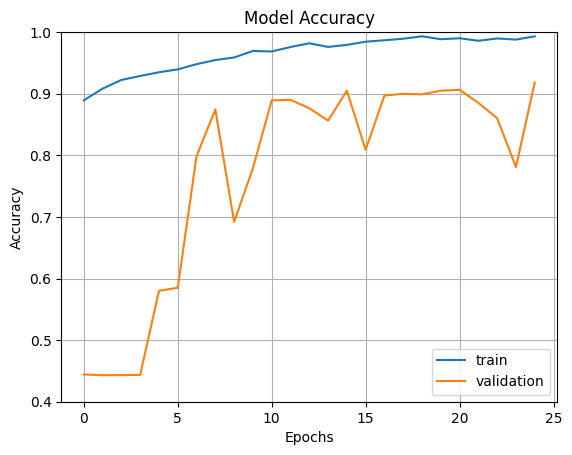

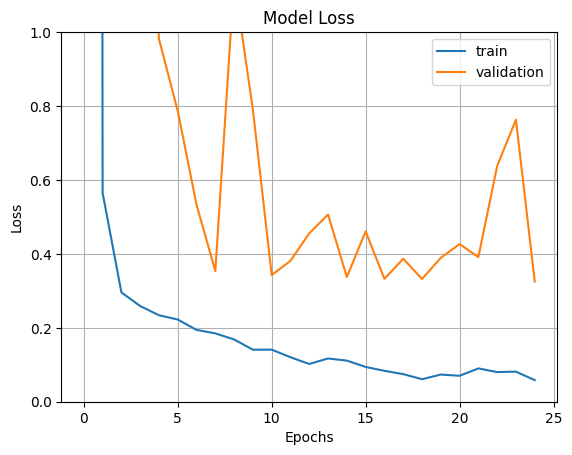

In [7]:
train_generator = CSET2_generator
validation_generator = SET2_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/25
 88/118 [=====================>........] - ETA: 10s - loss: 58.2840 - accuracy: 0.8865

2023-03-22 09:42:10.974771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 09:42:10.987175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

118/118 [==============================] - 106s 735ms/step - loss: 44.4076 - accuracy: 0.8939 - val_loss: 5.0271 - val_accuracy: 0.4429
Epoch 2/25
118/118 [==============================] - 52s 439ms/step - loss: 0.5238 - accuracy: 0.9184 - val_loss: 1.8426 - val_accuracy: 0.4428
Epoch 3/25
118/118 [==============================] - 51s 429ms/step - loss: 0.2743 - accuracy: 0.9263 - val_loss: 2.1973 - val_accuracy: 0.4434
Epoch 4/25
118/118 [==============================] - 51s 432ms/step - loss: 0.2614 - accuracy: 0.9291 - val_loss: 1.0151 - val_accuracy: 0.4436
Epoch 5/25
118/118 [==============================] - 50s 420ms/step - loss: 0.2451 - accuracy: 0.9322 - val_loss: 1.6746 - val_accuracy: 0.4620
Epoch 6/25
118/118 [==============================] - 49s 417ms/step - loss: 0.2120 - accuracy: 0.9453 - val_loss: 0.8187 - val_accuracy: 0.6185
Epoch 7/25
118/118 [==============================] - 51s 433ms/step - loss: 0.2001 - accuracy: 0.9482 - val_loss: 0.9614 - val_accuracy: 0

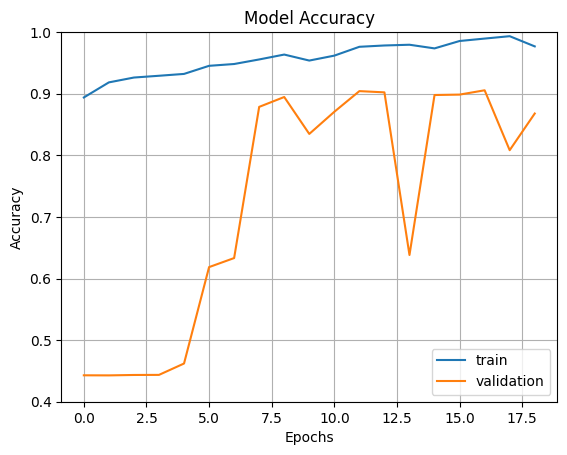

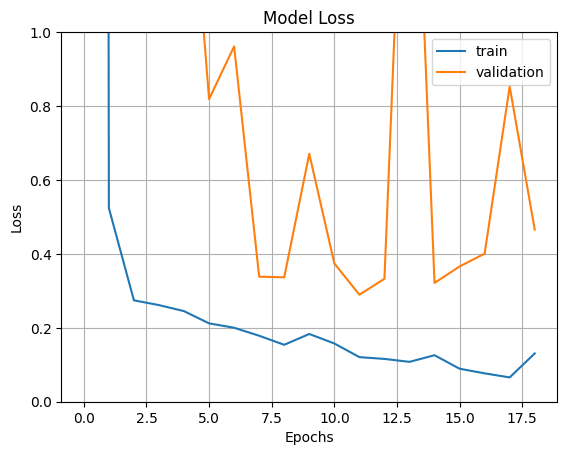

In [8]:
train_generator =  CSET3_generator
validation_generator = SET1_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

2023-03-22 09:58:33.110103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 32 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 09:58:33.137661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 32 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

4/4 [==============================] - 3s 28ms/step


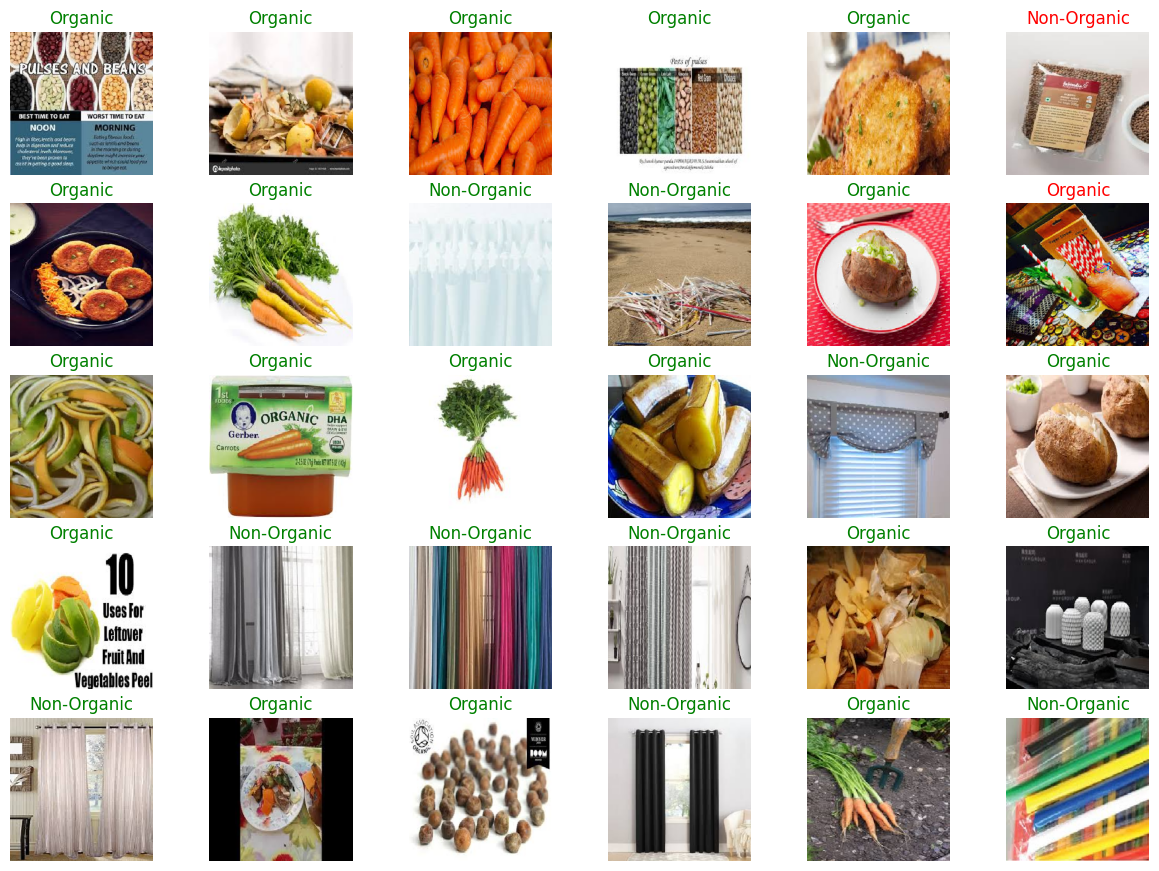

In [9]:
img, _= next(test_generator)
plt.figure(figsize=(15, 13))
result = model.predict(img)
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if result[i][1] < 0.5:
        pred = 0
        if pred == _[i][1]:
            plt.title("Organic", color='green')
        else: 
            plt.title("Organic", color='red')
    else:
        pred = 1
        if pred == _[i][1]:
            plt.title("Non-Organic", color='green')
        else: 
            plt.title("Non-Organic", color='red')
    plt.axis("off")